 # 20210112 - Raw Data
A loop back to analyzing the raw data. This is meant to be quite direct but will hopefully provide better direction for subsequent qowrk. Most important functions are placed in `utils/trx_utils.py`. Note that here we focus on two sets of data here: `exp1_cam1` which is the first camera from our long timescale data and '24h_bright' which is a dataset I gathered last weekend with significantly increased brightness and a verified light-dark cycle. We should note that we are, for the most part, using 120h of `exp1_cam1` and 24h of `24h_bright` data. Further, `24h_bright` was processed using a newer model. For associated videos, see the videos `analysis/notebooks/` and the (massive) raw videos are on google drive([long-timescale-static](https://drive.google.com/drive/u/1/folders/1BFXIEEp_KnmDSPjONEU5h-CuK0-qy4ud))

In [1]:
import logging
from seaborn.distributions import distplot
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import pandas as pd
import h5py
import numpy as np
from pathlib import Path
import os
from datetime import datetime
import importlib

wd = "/Genomics/ayroleslab2/scott/long-timescale-behavior/analysis/"
os.chdir(wd)

import utils.trx_utils as trx_utils

data_dir = "/Genomics/ayroleslab2/scott/long-timescale-behavior/data/"
track_dir = "/Genomics/ayroleslab2/scott/long-timescale-behavior/data/tracks/"
plots_dir = "/Genomics/ayroleslab2/scott/long-timescale-behavior/analysis/plots/"

logging.basicConfig(
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO,
    datefmt="%H:%M:%S",
)
logger = logging.getLogger("analysis_logger")

# Metadata
Build up a dict containing all of our experimental metadata so that we don't need to manually enter it all through the notebook.

In [5]:
exp1_cam1_h5s = [
    "exp2_cam1_0through23.tracked.analysis.h5",
    # "exp2_cam1_24through47.tracked.analysis.h5",
    # "exp2_cam1_48through71.tracked.analysis.h5",
    # "exp2_cam1_72through95.tracked.analysis.h5",
    # "exp2_cam1_96through119.tracked.analysis.h5",
]
exp1_cam1_h5s = [track_dir + filename for filename in exp1_cam1_h5s]

bright_h5s = ["24h_bright_0through23_0through29.tracked.analysis.h5"]
bright_dir = "/Genomics/ayroleslab2/scott/long-timescale-behavior/tmp/24h_bright/"
bright_h5s = [bright_dir + filename for filename in bright_h5s]

FMT = "%w-%H:%M:%S"

# Build with dict for compatibility with JSON
expmt_dict = {
    "exp1_cam1": {
        "h5s": exp1_cam1_h5s,
        "video": "exp1_cam1.mkv",
        "frame_rate": 100,
        "start_time": datetime.strptime("0-22:33:00", FMT),
        "camera": "1",
        "experiment": "1",
        "video_path": "/Genomics/ayroleslab2/scott/long-timescale-behavior/data/exp1/exp5_202109014_2233/Camera1/exp.mkv",
        "px_mm": 28.25,
    },
    "24h_bright": {
        "h5s": bright_h5s,
        "video": "/Genomics/ayroleslab2/scott/long-timescale-behavior/tmp/24h_bright/24h_bright.mkv",
        "frame_rate": 99.96,
        "start_time": datetime.strptime("0-12:00:00", FMT),
        "camera": "1",
        "experiment": "24h_bright",
        "video_path": "/Genomics/ayroleslab2/scott/long-timescale-behavior/tmp/24h_bright/24h_bright.mkv",
        "px_mm": 28.25,
    },
}
px_mm = expmt_dict["exp1_cam1"]["px_mm"]

 # Load h5 traces and match by quadrant
 For reference, fly node locations are in the form (time, node, coord, fly_idx). The frequency and assignments are logged here but are not necessary for understanding the subsequent analysis. We expect 120\*60\*60\*100 = 43,200,000 frames for first 120h of `exp1_cam1` and 24\*60\*60\*99.96 = 8,636,544 frames for `24h_bright`. The missing values here are just locations where the thorax was not identified.

In [6]:
expmt_dict,tracks_dict_raw = trx_utils.load_tracks(expmt_dict)

11:38:40 INFO: Loading exp1_cam1
11:38:40 INFO: /Genomics/ayroleslab2/scott/long-timescale-behavior/data/tracks/exp2_cam1_0through23.tracked.analysis.h5
11:39:08 INFO: Experiment: {'h5s': ['/Genomics/ayroleslab2/scott/long-timescale-behavior/data/tracks/exp2_cam1_0through23.tracked.analysis.h5'], 'video': 'exp1_cam1.mkv', 'frame_rate': 100, 'start_time': datetime.datetime(1900, 1, 1, 22, 33), 'camera': '1', 'experiment': '1', 'video_path': '/Genomics/ayroleslab2/scott/long-timescale-behavior/data/exp1/exp5_202109014_2233/Camera1/exp.mkv', 'px_mm': 28.25, 'node_names': ['head', 'eyeL', 'eyeR', 'thorax', 'abdomen', 'forelegL', 'forelegR', 'midlegL', 'midlegR', 'hindlegL', 'hindlegR', 'wingL', 'wingR', 'proboscis']}
11:39:08 INFO: Final frequencies: [array([[8639954.,       0.],
       [      0.,       0.]]), array([[      0., 8639967.],
       [      0.,       0.]]), array([[      0.,       0.],
       [8639969.,       0.]]), array([[      0.,       0.],
       [      0., 8639959.]])]
11

# Process raw tracks
Processing the raw tracks as needed and generating corresponding velocities. Note that the velocities use `np.gradient` which uses the central difference for interior points and either first order one-sided difference for the first and last point. We're not using the velocity extensively in this notebook but it's useful to use as a sanity check and helped me to select frames of interest.

In [7]:
importlib.reload(trx_utils)
tracks_dict = {}
velocities_dict = {}

for key in expmt_dict:
    expmt = expmt_dict[key]
    fly_node_locations = tracks_dict_raw[key].copy()
    fly_node_locations = trx_utils.fill_missing_np(fly_node_locations)

    fly_node_velocities = (
        trx_utils.instance_node_velocities(
            fly_node_locations, 0, fly_node_locations.shape[0]
        )
        * (1 / px_mm)
        * expmt["frame_rate"]
    )
    tracks_dict[key] = fly_node_locations
    velocities_dict[key] = fly_node_velocities


100%|██████████| 14/14 [00:05<00:00,  2.52it/s]


 # Save
 Save the JSON and h5s if needed. We'll avoid using high compression options to keep our time cost low. This is one step where we can save a ton of disk space when we're done.

In [5]:
import json
json.dump(expmt_dict, open("expmt_dict.json", "w"), default=str)

for key in tqdm(expmt_dict):
    data_file = h5py.File(data_dir + f"{key}_fly_node_locations.h5", "w")
    data_file.create_dataset(
        "tracks", data=tracks_dict[key]
    )  # , compression='lzf') #'gzip', compression_opts=9)
    data_file.close()

    data_file = h5py.File(data_dir + f"{key}_fly_node_velocities.h5", "w")
    data_file.create_dataset(
        "velocities", data=velocities_dict[key]
    )  # , compression='lzf') #'gzip', compression_opts=9)
    data_file.close()


100%|██████████| 2/2 [01:35<00:00, 47.85s/it]


# Load in processed tracks
This saves a good chunk of time by skipping the first section of the notebook.

In [3]:
import json

expmt_dict = json.load(open("expmt_dict.json", "r"))
node_names = expmt_dict["exp1_cam1"]["node_names"]
px_mm = expmt_dict["exp1_cam1"]["px_mm"]
tracks_dict = {}
velocities_dict = {}
for key in tqdm(expmt_dict):
    with h5py.File(data_dir + f"/{key}_fly_node_locations.h5", "r") as f:
        tracks_dict[key] = f["tracks"][:]
    with h5py.File(data_dir + f"/{key}_fly_node_velocities.h5", "r") as f:
        velocities_dict[key] = f["velocities"][:]


100%|██████████| 2/2 [02:40<00:00, 80.40s/it] 


# Time series check

Note that we need to be super careful about the axes as they vary between plots.  We start off by plotting a minute start from the beggining of the experiment where all four individuals are not moving. It appears that at least some portion of our data is fairly quantized For example, when looking at the x position of the first track (exp1_cam1, fly0) we can see the repeated oscillation between ~172.1 and ~172.8. However, if we take a look at the x coordinate of the second track (exp1_cam1, fly1) we can see that the data in a much tighter band between ~522.9 and 523.1.

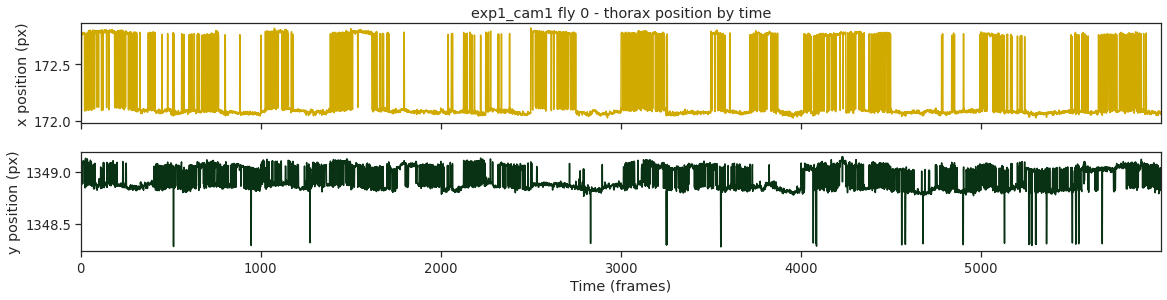

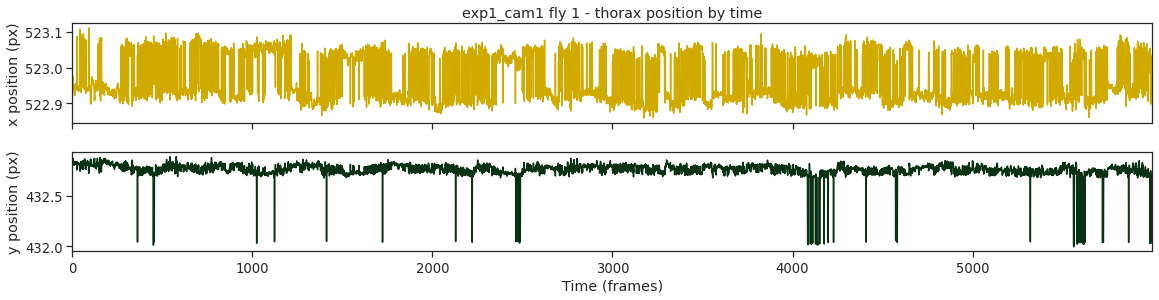

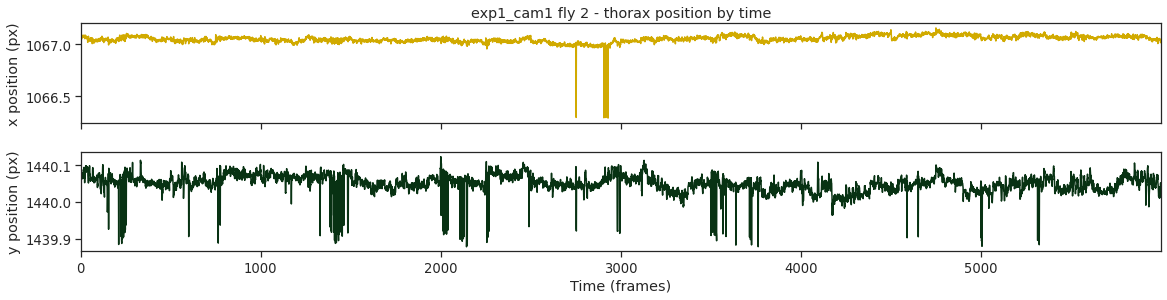

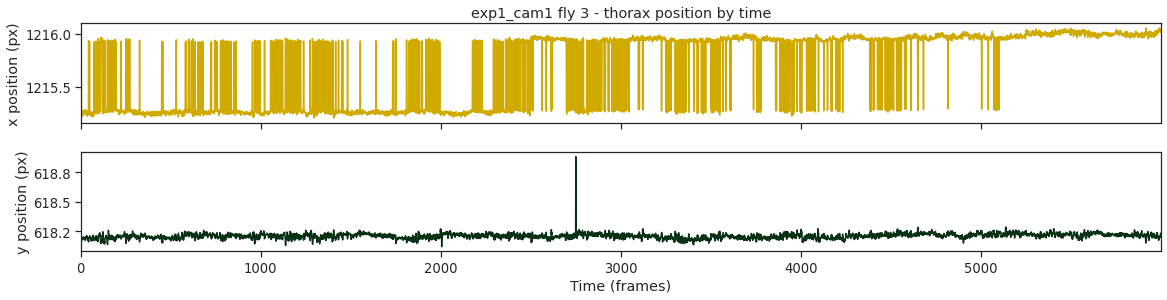

In [7]:
expmt_name = "exp1_cam1"
frame_start = 0
frame_end = int(frame_start + 60 * 100)
vels = velocities_dict[expmt_name]

# trx_utils.plot_timeseries(tracks_dict[expmt_name],vels,node_idx=node_names.index("thorax"),frame_start=frame_start,frame_end=frame_end, title = expmt_name,output_name = f'{expmt_name}_thorax_timeseries.png',path='')
trx_utils.plot_timeseries(
    tracks_dict[expmt_name],
    [0, 1, 2, 3],
    vels=None,
    node_idx=node_names.index("thorax"),
    frame_start=frame_start,
    frame_end=frame_end,
    title=expmt_name,
    output_name=f"{expmt_name}_thorax_timeseries.png",
    path="",
)


## Moving
Now lets take a look at when some individuals are moving. Here we take a look at another 60 second window when three individuals are moving.

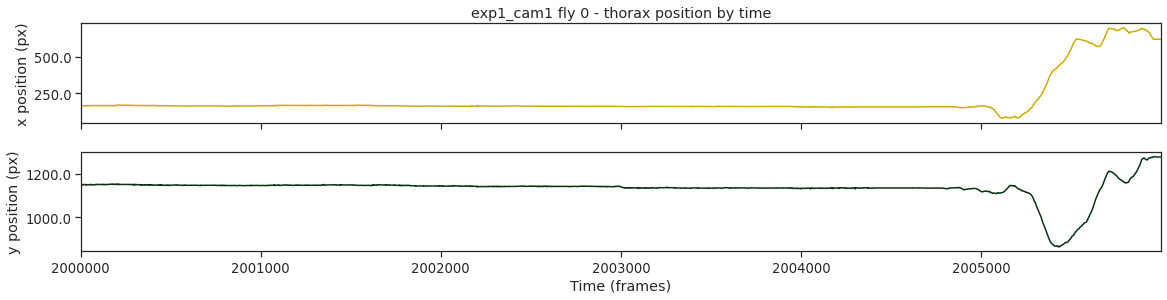

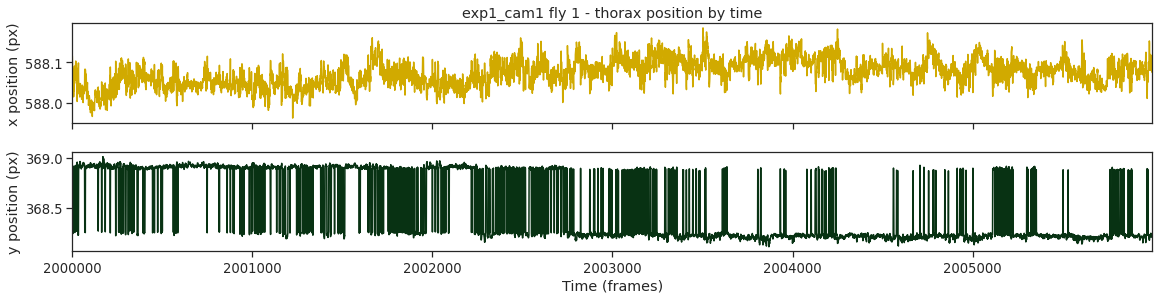

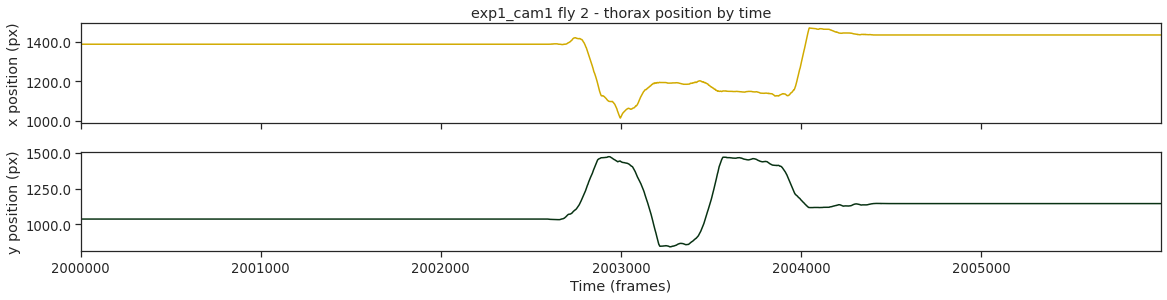

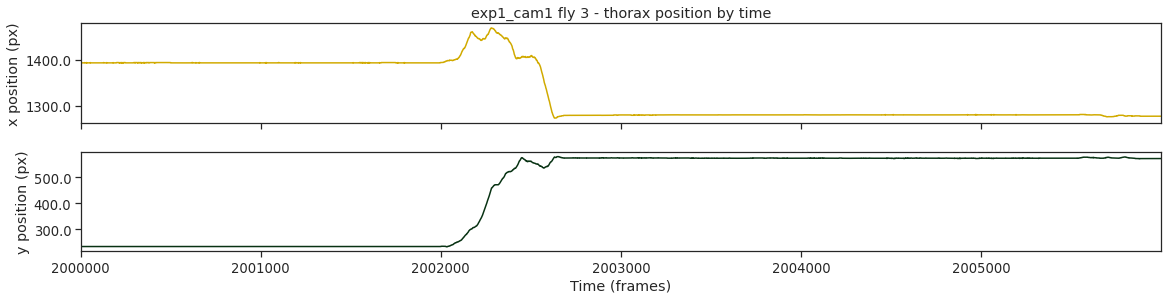

In [10]:
import time
expmt_name = "exp1_cam1"
frame_start = 20000 * 100
frame_end = int(frame_start + 60 * 100)
trx_utils.plot_timeseries(
    tracks_dict[expmt_name],
    [0, 1, 2, 3],
    vels=None,
    node_idx=node_names.index("thorax"),
    frame_start=frame_start,
    frame_end=frame_end,
    title=expmt_name,
    output_name=f'{time.strftime("%Y%m%d_%H%M%S")}_{frame_start}to{frame_end}_{expmt_name}_thorax_timeseries.png',
    path="",
)


Now lets take a closer look at the x coordinate of the first track (exp1_cam1, fly0) and see what it looks like when the fly is moving. Here we zoom in to a 1/10 sec region. Notice the much smoother transitions.

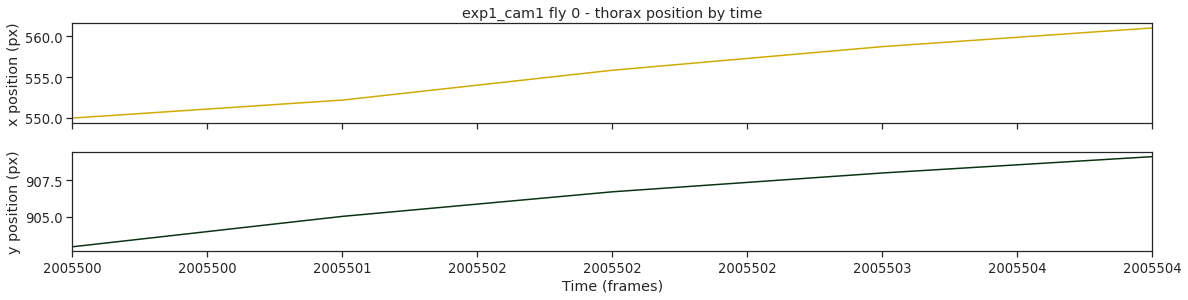

In [11]:
importlib.reload(trx_utils)
expmt_name = "exp1_cam1"
frame_start = 20055 * 100
frame_end = int(frame_start + 0.05 * 100)
trx_utils.plot_timeseries(
    tracks_dict[expmt_name],
    [0],
    vels=None,
    node_idx=node_names.index("thorax"),
    frame_start=frame_start,
    frame_end=frame_end,
    title=expmt_name,
    output_name=f'{time.strftime("%Y%m%d_%H%M%S")}_{frame_start}to{frame_end}_{expmt_name}_thorax_timeseries_zoomed.png',
    path="",
)


# What happens if we dig into the highest velocity locations?

The tracks below show the timeseries at the max velocity. The max velocity frames for a given location are almost always errors and not representative of the "true" behavior.

23:20:04 INFO: "Plotting fly 0, node thorax, max vel 414.882712974806 at frame 9576770


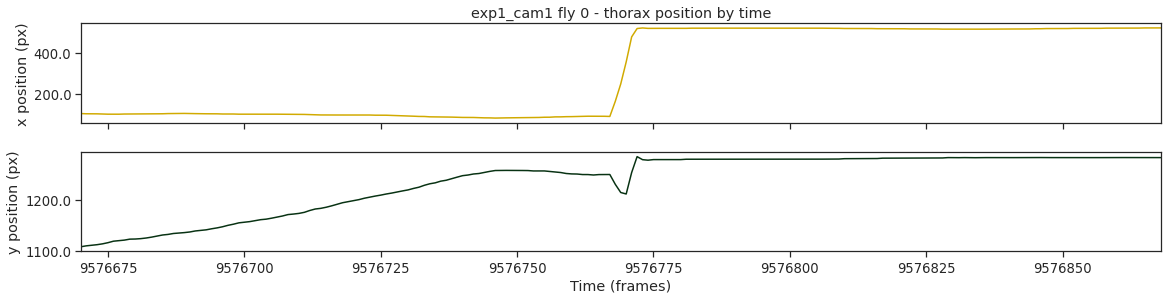

23:20:04 INFO: "Plotting fly 0, node thorax, max vel 414.882712974806 at frame 9576770


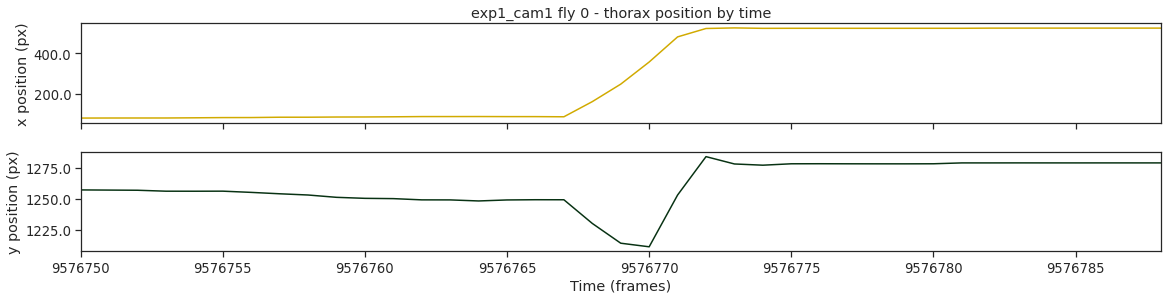

In [12]:
expmt_name = "exp1_cam1"
fly_idx = 0
width = 100
node = node_names.index("thorax")
vel_max = np.argmax(velocities_dict[expmt_name][:, node, fly_idx])
importlib.reload(trx_utils)
logger.info(f'"Plotting fly {fly_idx}, node {node_names[node]}, max vel {velocities_dict[expmt_name][vel_max, node, fly_idx]} at frame {vel_max}')
frame_start = vel_max - width
frame_end = int(frame_start +  2*width -1)
trx_utils.plot_timeseries(
    tracks_dict[expmt_name],
    [fly_idx],
    vels=None,
    node_idx=node,
    frame_start=frame_start,
    frame_end=frame_end,
    title=expmt_name,
    output_name=f'{time.strftime("%Y%m%d_%H%M%S")}_{frame_start}to{frame_end}_{expmt_name}_thorax_timeseries_zoomed.png',
    path="",
)

width=20
logger.info(f'"Plotting fly {fly_idx}, node {node_names[node]}, max vel {velocities_dict[expmt_name][vel_max, node, fly_idx]} at frame {vel_max}')
frame_start = vel_max - width
frame_end = int(frame_start +  2*width-1)
trx_utils.plot_timeseries(
    tracks_dict[expmt_name],
    [fly_idx],
    vels=None,
    node_idx=node,
    frame_start=frame_start,
    frame_end=frame_end,
    title=expmt_name,
    output_name=f'{time.strftime("%Y%m%d_%H%M%S")}_{frame_start}to{frame_end}_{expmt_name}_thorax_timeseries_zoomed.png',
    path="",
)


# Smoothing

Now if we walk back to our initial quantized plots, we can attempt to remove the spike noise and separate peaks from the baseline. Particularly when individuals are stationary, this helps us reduce the noise in our data.

In [13]:

tracks_dict_median = {}
for key in tqdm(expmt_dict):
    expmt = expmt_dict[key]
    fly_node_locations = tracks_dict[key]#.copy()
    fly_node_locations = fly_node_locations[0:(1*60*60*100), :, :, :]

    fly_node_locations = trx_utils.smooth_median(fly_node_locations, window=11)
    tracks_dict_median[key] = fly_node_locations


100%|██████████| 2/2 [00:40<00:00, 20.50s/it]


## Reduction in spike noise
Here we show the reduction in spike noise on a single minute of thorax traces. It appears that a median filter with window size of 11 removes a large amount of spike noise and thus can be used to reduce the noise in our subsequent metrics like velocity.

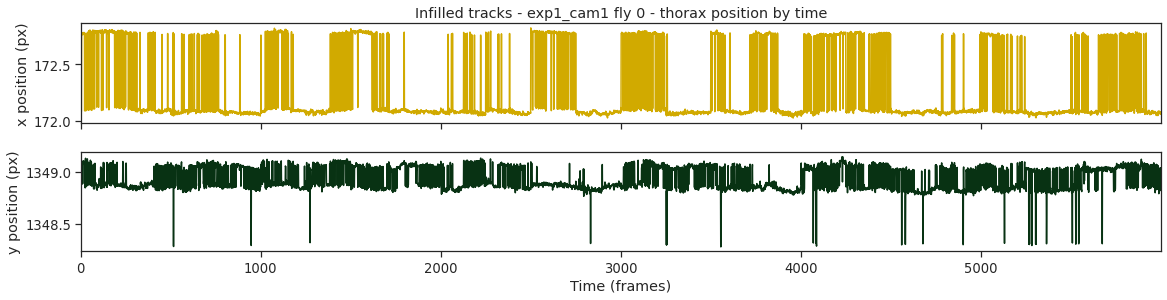

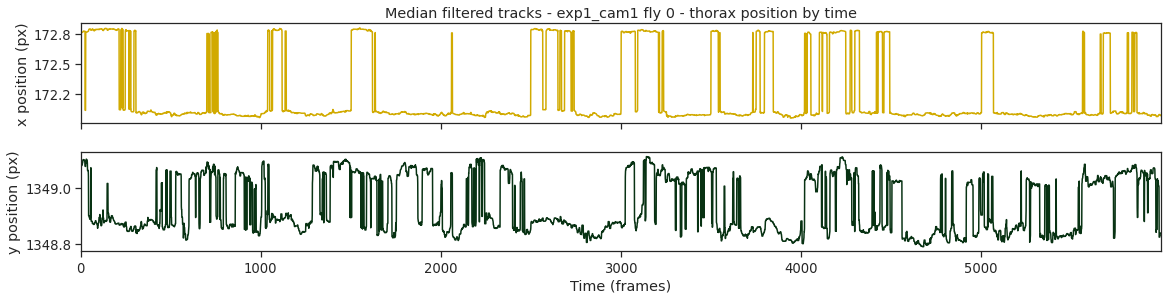

In [15]:
expmt_name = "exp1_cam1"
frame_start = 0
frame_end = int(frame_start + 60 * 100)
vels = velocities_dict[expmt_name]

trx_utils.plot_timeseries(
    tracks_dict[expmt_name],
    [0],
    vels=None,
    node_idx=node_names.index("thorax"),
    frame_start=frame_start,
    frame_end=frame_end,
    title=f'Infilled tracks - {expmt_name}',
    output_name=f"{expmt_name}_thorax_timeseries.png",
    path="",
)

trx_utils.plot_timeseries(
    tracks_dict_median[expmt_name],
    [0],
    vels=None,
    node_idx=node_names.index("thorax"),
    frame_start=frame_start,
    frame_end=frame_end,
    title=f'Median filtered tracks - {expmt_name}',
    output_name=f"{expmt_name}_thorax_timeseries.png",
    path="",
)

# Speed distributions

Here we plot the speed distributions -- central difference except on edges calculated by `np.gradient` -- for `exp1_cam1` and `24h_bright`. Here we use the infilled data without any smoothing. One very concerning aspect is that we see *drastically* more movement in the 24h_bright data than in the exp1_cam1 data. We can also see the tendency to move in pixel steps just as we would expect from the quantization described above. 

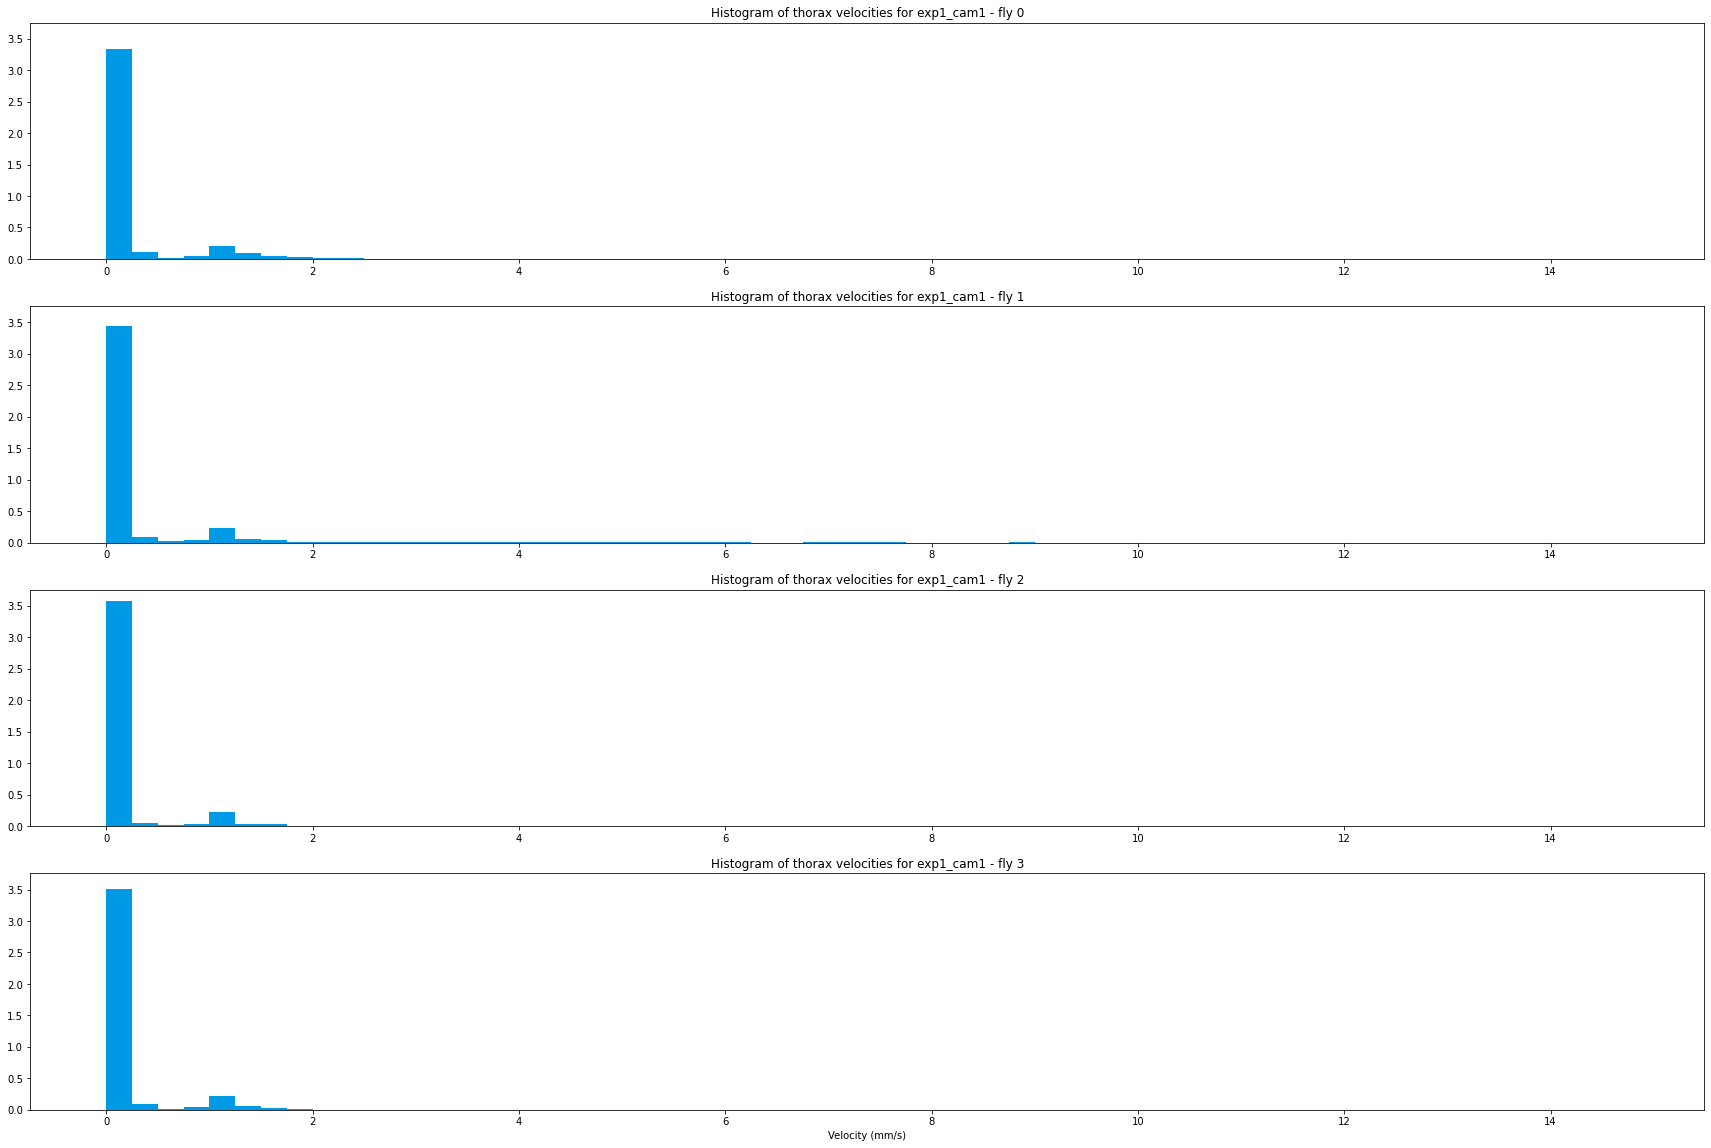

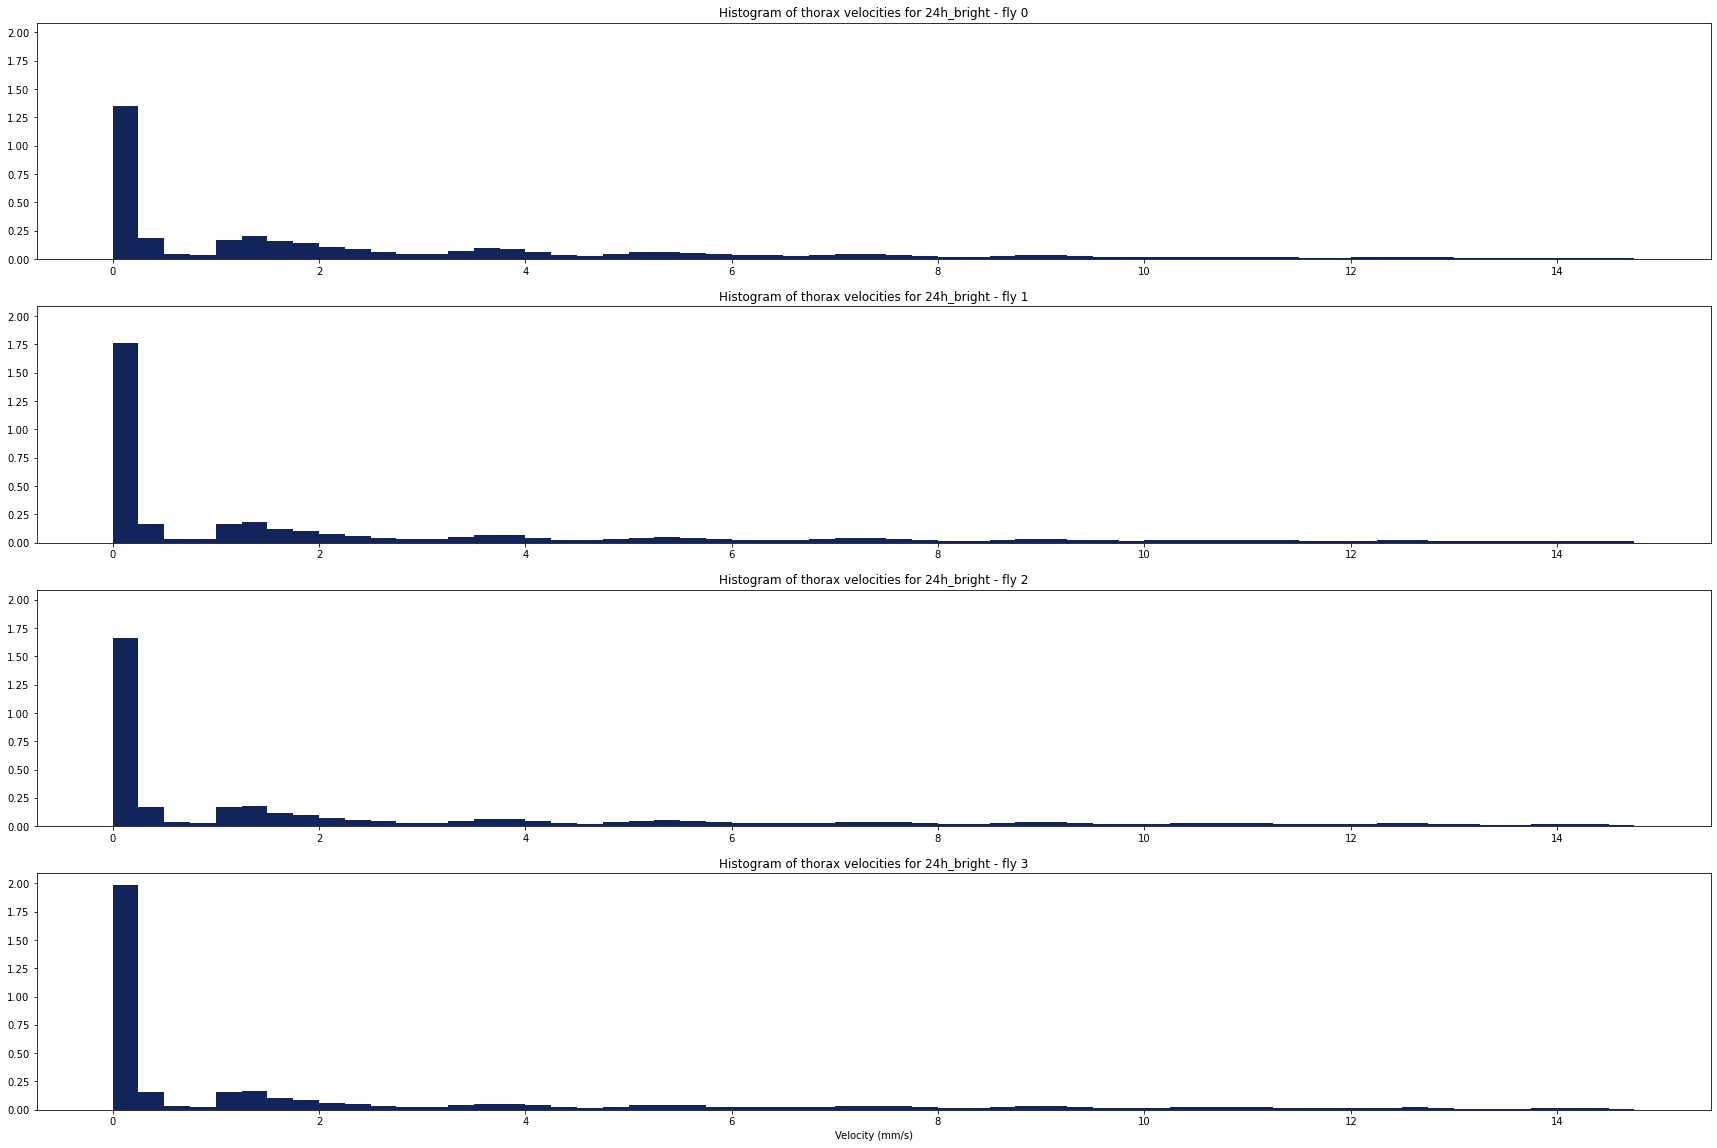

In [53]:
import palettable
import time

# We use sharey to make sure the plots are all use the same y-axis so we can easily compare within experiment.
for expmt_id in np.arange(len(list(expmt_dict.keys()))):
    expmt_name = list(expmt_dict.keys())[expmt_id]
    fig, ax = plt.subplots(4, 1, figsize=(30, 20),sharey=True)
    for fly_id in np.arange(tracks_dict[expmt_name].shape[3]):
        ax[fly_id].hist(
            velocities_dict[expmt_name][:, node_names.index("thorax"), fly_id],
            bins=np.arange(0, 15, 0.25),
            color=palettable.wesanderson.Zissou_5.mpl_colors[expmt_id],
            density=True,
        )
        ax[fly_id].set_title(f"Histogram of thorax velocities for {expmt_name} - fly {fly_id}")
        # ax[fly_id].set_yscale("log")
        fig.savefig(
            f'{time.strftime("%Y%m%d_%H%M")}_{expmt_name}_fly{fly_id}_thorax_velocities.png'
        )
    ax[3].set_xlabel("Velocity (mm/s)")


# Video plotting
Good for documentation and debugging but to this should ignored until we're happy with timeseries analysis.

In [ ]:
%%capture
# Plot traces on individuals/video as needed

import time
importlib.reload(trx_utils)
expmt_name = 'exp1_cam1'
frame_start = 20025*100
frame_end = int(frame_start + 60*100)

trx_utils.plot_trx(tracks_dict[expmt_name],expmt_dict[expmt_name]["video_path"],frame_start,frame_end,output_path=f'{time.strftime("%Y%m%d_%H%M%S")}_{frame_start}to{frame_end}_{expmt_name}_trx')

In [91]:
from IPython.display import Video
import os

cwd = os.getcwd()
Video("/Genomics/ayroleslab2/scott/long-timescale-behavior/analysis/notebooks/example_trace.mp4")

In [ ]:
# A simple example of the plot_ego function

importlib.reload(trx_utils)
expmt_name = "24h_bright"
frame_start = int(27145 * 100)
frame_end = int(27145 * 100 + 600 * 100)

for fly_id in range(tracks_dict[expmt_name].shape[3]):
    egocentric_node_locations, egocentric_angles = trx_utils.normalize_to_egocentric(
        tracks_dict[expmt_name][:, :, :, fly_id],
        ctr_ind=node_names.index("thorax"),
        fwd_ind=node_names.index("head"),
        return_angles=True,
    )
    # egocentric_angles=None
    trx_utils.plot_ego(
        tracks_dict[expmt_name],
        expmt_dict[expmt_name]["video_path"],
        egocentric_angles,
        [fly_id],
        node_names.index("thorax"),
        frame_start,
        frame_end,
        output_path=f'{time.strftime("%Y%m%d_%H%M%S")}_{frame_start}to{frame_end}_{expmt_name}_fly{fly_id}_raw_ego.mp4',
    )
    egocentric_velocities = (
        trx_utils.instance_node_velocities(
            egocentric_node_locations, 0, egocentric_node_locations.shape[0]
        )
        * (1 / px_mm)
        * expmt["frame_rate"]
    )


In [92]:
from IPython.display import Video
import os

cwd = os.getcwd()
Video("/Genomics/ayroleslab2/scott/long-timescale-behavior/analysis/notebooks/example_raw_ego.mp4")

# Circadian rhythm

Good for documentation -- to be ignored for now.

In [ ]:
import scipy.stats
from datetime import datetime

ToD = {}
for expmt in expmt_dict:
    expmt_data = expmt_dict[expmt]
    FMT = "%w-%H:%M:%S"
    start_day = datetime.strptime(
        "1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"
    )  # for example
    try:
        time = datetime.strptime(expmt_data["start_time"], "%Y-%m-%d %H:%M:%S")
    except:
        time = expmt_data["start_time"]
    expmt_data["start_time"] = time
    difference = start_day - time
    frame_rate = expmt_data["frame_rate"]
    shift = int(difference.seconds * frame_rate)
    frame_idx = np.arange(tracks_dict[expmt].shape[0]) - shift
    expmt_tod = (frame_idx % int(24 * 60 * 60 * frame_rate)) / (
        1 * 60 * 60 * frame_rate
    )
    ToD[expmt] = expmt_tod

day_start = 8
day_end = 20
day_dict = {}
for expmt in expmt_dict:
    day_dict[expmt] = (ToD[expmt] > day_start) & (ToD[expmt] < day_end)

plt.rcParams["patch.linewidth"] = 0
plt.rcParams["patch.edgecolor"] = "none"
plt.rcParams["figure.figsize"] = (9, 3)
plt.rcParams["figure.dpi"] = 300


In [ ]:
for expmt in expmt_dict:
    vels = velocities_dict[expmt].copy()
    day = (ToD[expmt] > day_start) & (ToD[expmt] < day_end)
    for fly_idx in range(vels.shape[2]):
        fly_thorax_vel = vels[:, node_names.index("thorax"), fly_idx]
        # fly_thorax_vel[fly_thorax_vel < 3*(1/28.25)*100] = 0
        binned = scipy.stats.binned_statistic(
            day.astype(int),
            fly_thorax_vel,
            statistic="mean",
            bins=[0, 0.5, 1],
            range=None,
        )
        sns.barplot(x=["Night", "Day"], y=binned.statistic)
        plt.title(f"{expmt} - Fly {fly_idx} - Mean thorax velocity by day/night")
        plt.show()

        sns.boxplot(x=day.astype(int), y=fly_thorax_vel, showfliers=False)
        plt.title(f"{expmt} - Fly {fly_idx} - Mean thorax velocity by day/night")
        plt.show()
        logger.info(f"{expmt} {fly_idx}")
        segments = 2 * 24

        binned = scipy.stats.binned_statistic(
            ToD[expmt], fly_thorax_vel, statistic="mean", bins=segments, range=None
        )
        custom_params = {"axes.spines.right": False, "axes.spines.top": False}
        sns.set_theme(style="ticks", rc=custom_params)
        fig, ax = plt.subplots()
        sns.barplot(
            ax=ax,
            x=np.arange(segments),
            y=binned.statistic,
            color=palettable.wesanderson.GrandBudapest4_5.mpl_colors[0],
        )  # ,alpha=1,width=1)
        plt.xticks([i * (segments // 24) for i in [0, 8, 20, 24]], [0, 8, 20, 24])
        plt.tight_layout(pad=2)
        # ax.set_yscale('log')
        def change_width(ax, new_value):
            for patch in ax.patches:
                current_width = patch.get_width()
                diff = current_width - new_value

                # we change the bar width
                patch.set_width(new_value)

                # we recenter the bar
                patch.set_x(patch.get_x() + diff * 0.5)

        plt.xlabel("Hour of the day")
        plt.ylabel("Mean thorax velocity (mm/s)")
        plt.title("Mean thorax velocity by hour of the day")
        change_width(ax, 0.95)
        plt.savefig(f"{expmt}_fly{fly_idx}_thorax_velocity_by_hour_of_day.png")
        plt.show()


## Periodogram 
Direct scipy periodogram example. It's fairly reassuring that we an intial look finds roughly the same frequency that previous work found. One main issue comes from the fact if we don't segment to when individuals are moving, the noise in the data seems to obscure any signal we would find.

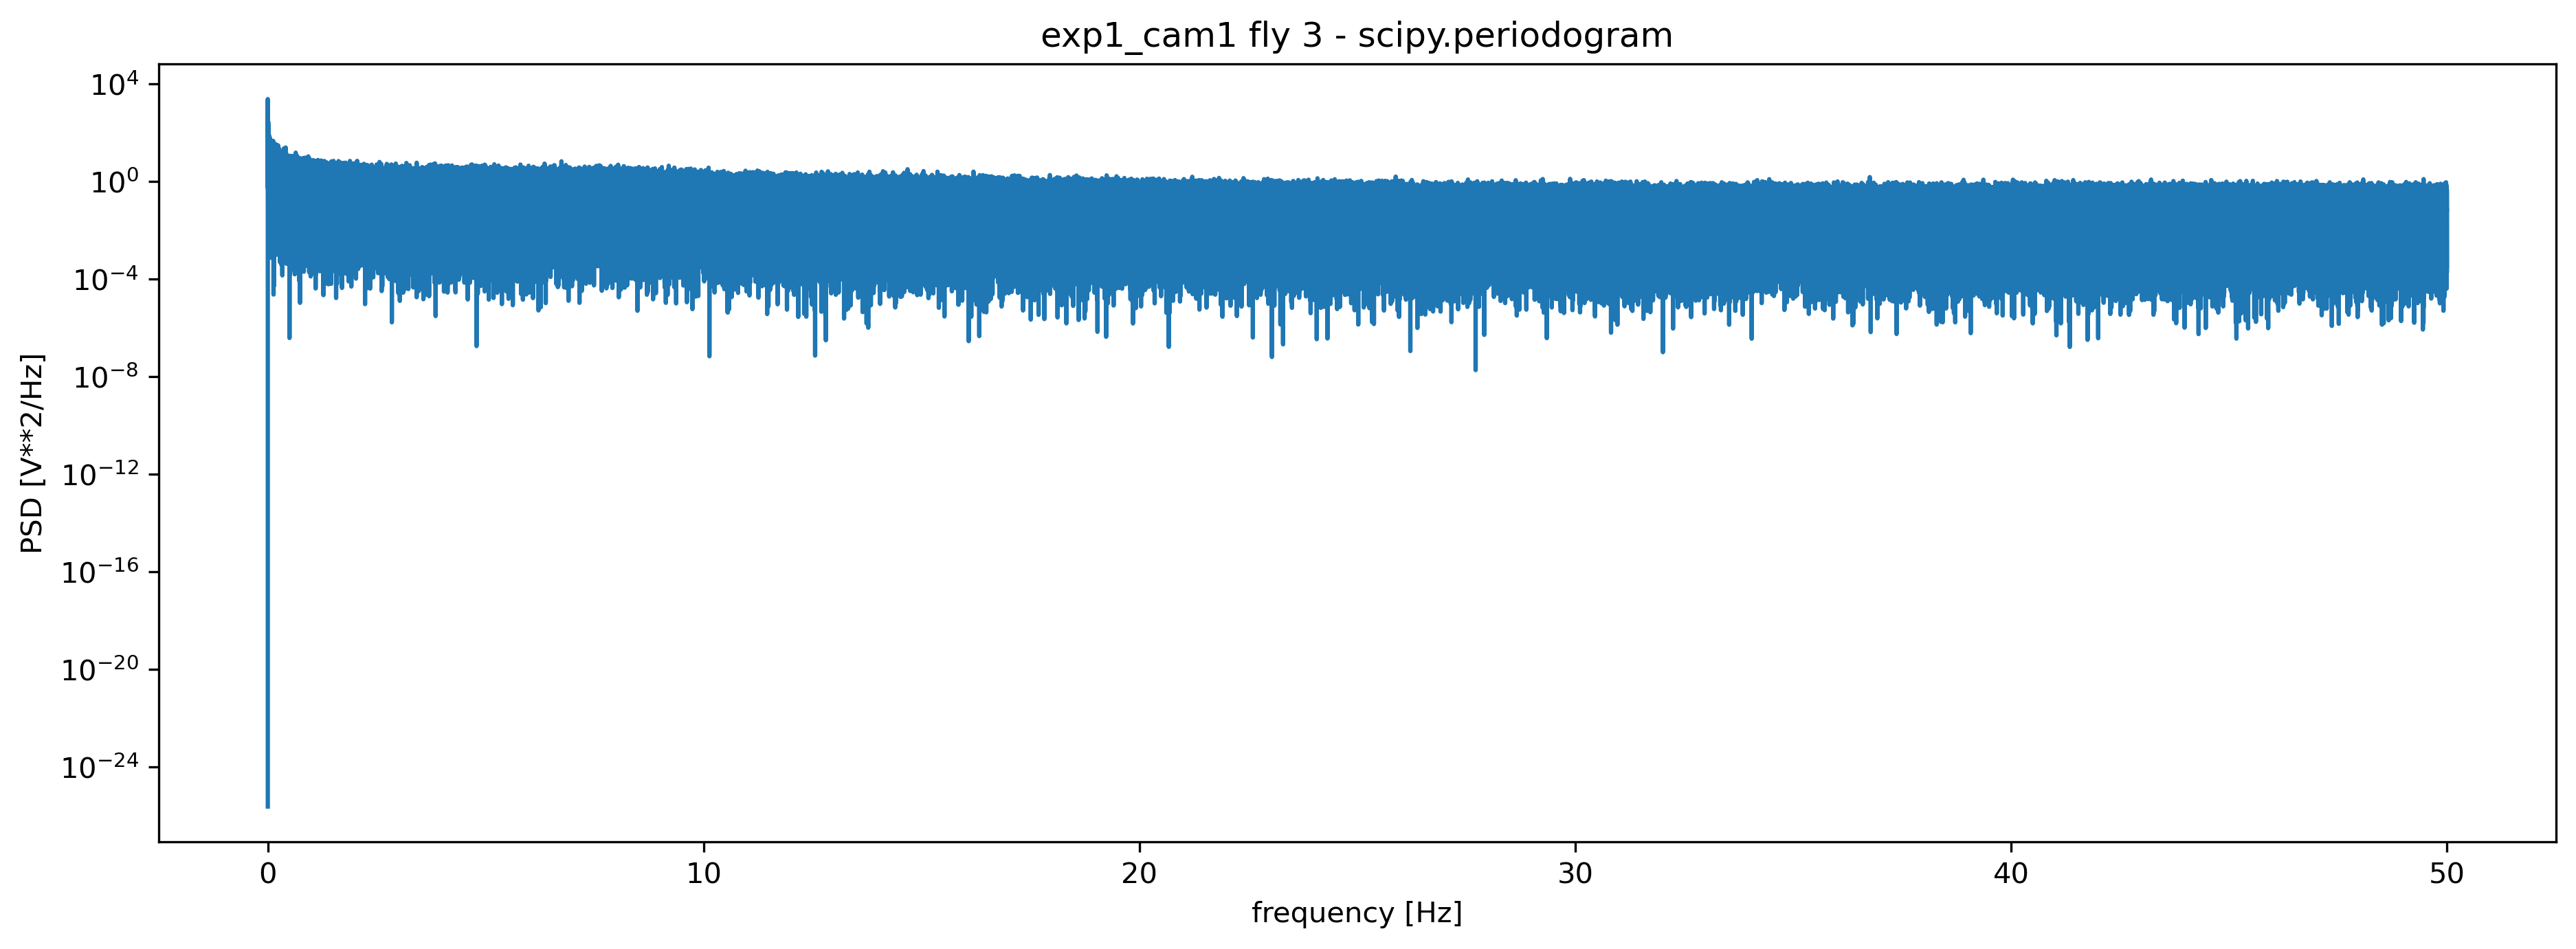

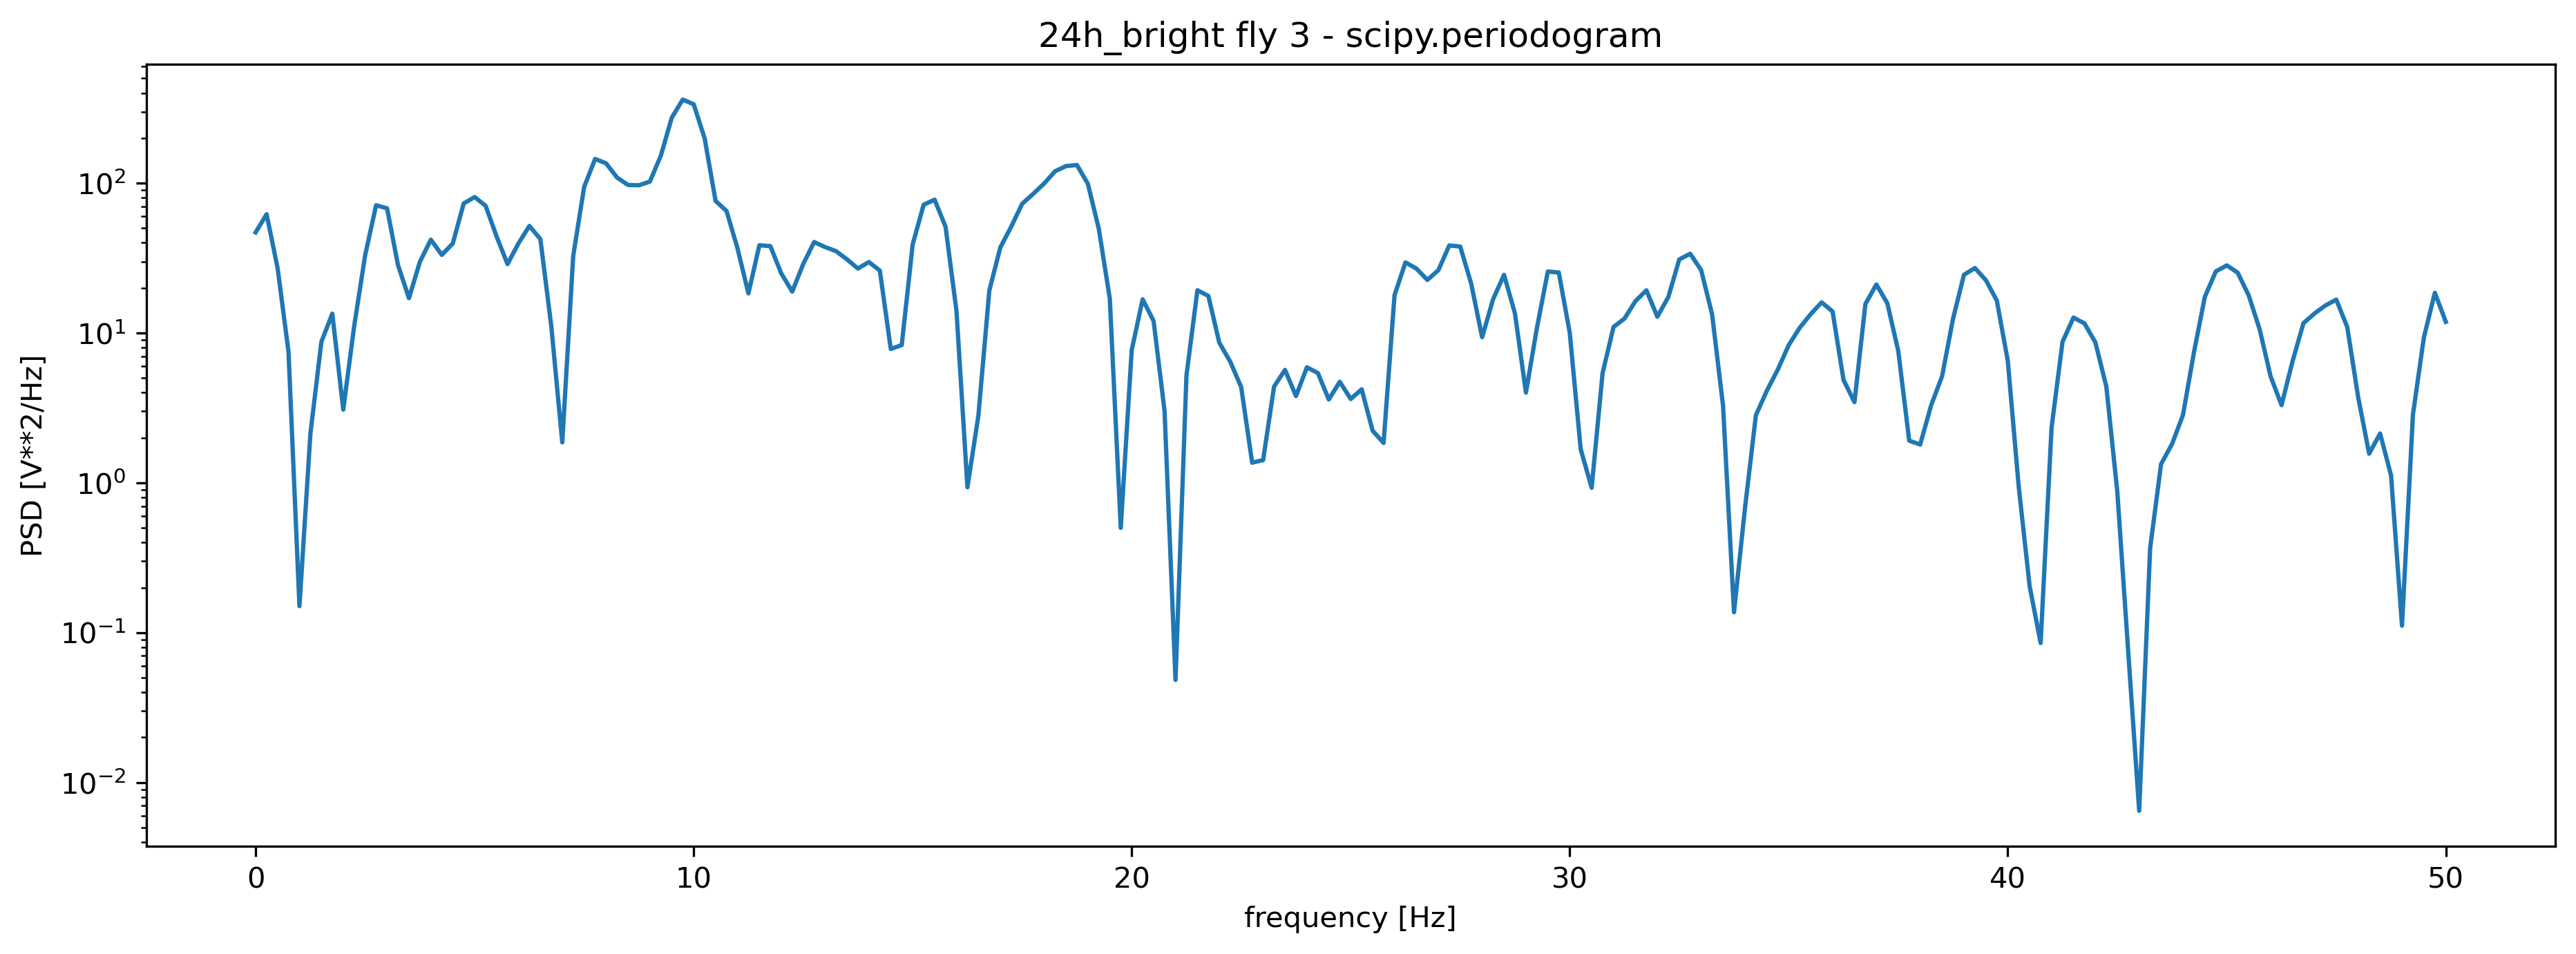

In [70]:
import scipy

fly_id = 3
expmt_name = "exp1_cam1"
node_name = "midlegL"

vels = velocities_dict[expmt_name][:, node_names.index(node_name), fly_id]
vels_len = vels.shape[0]

# Note that boxcar here is the same the default
f, Pxx = scipy.signal.periodogram(
    vels,
    fs=100,
    window=scipy.signal.get_window(("boxcar"), vels_len),
    scaling="density",
)
plt.figure(figsize=(15,5),dpi=300)
plt.semilogy(f, Pxx)
plt.title(f"{expmt_name} fly {fly_id} - scipy.periodogram")
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.show()


# We lets check on 24h_bright as well
fly_id = 3
expmt_name = "24h_bright"
# Subset to when the fly is moving to test this out
vels = velocities_dict[expmt_name][:, node_names.index(node_name), fly_id][200:600]
vels_len = vels.shape[0]

f, Pxx = scipy.signal.periodogram(
    vels,
    fs=100,
    window=scipy.signal.get_window(("flattop"), vels_len),
    scaling="density",
)
plt.figure(figsize=(15,5),dpi=300)
plt.semilogy(f, Pxx)
plt.title(f"{expmt_name} fly {fly_id} - scipy.periodogram")
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.show()


## Spectrogram example
Just a quick example -- to be ignored for now.

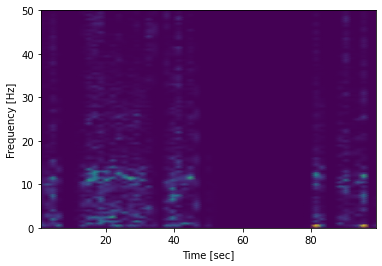

In [126]:
f, t, Sxx = scipy.signal.spectrogram(
    vels, fs=100, window=scipy.signal.get_window(("boxcar"), 200)
)
plt.pcolormesh(t, f, Sxx, shading="gouraud")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.show()


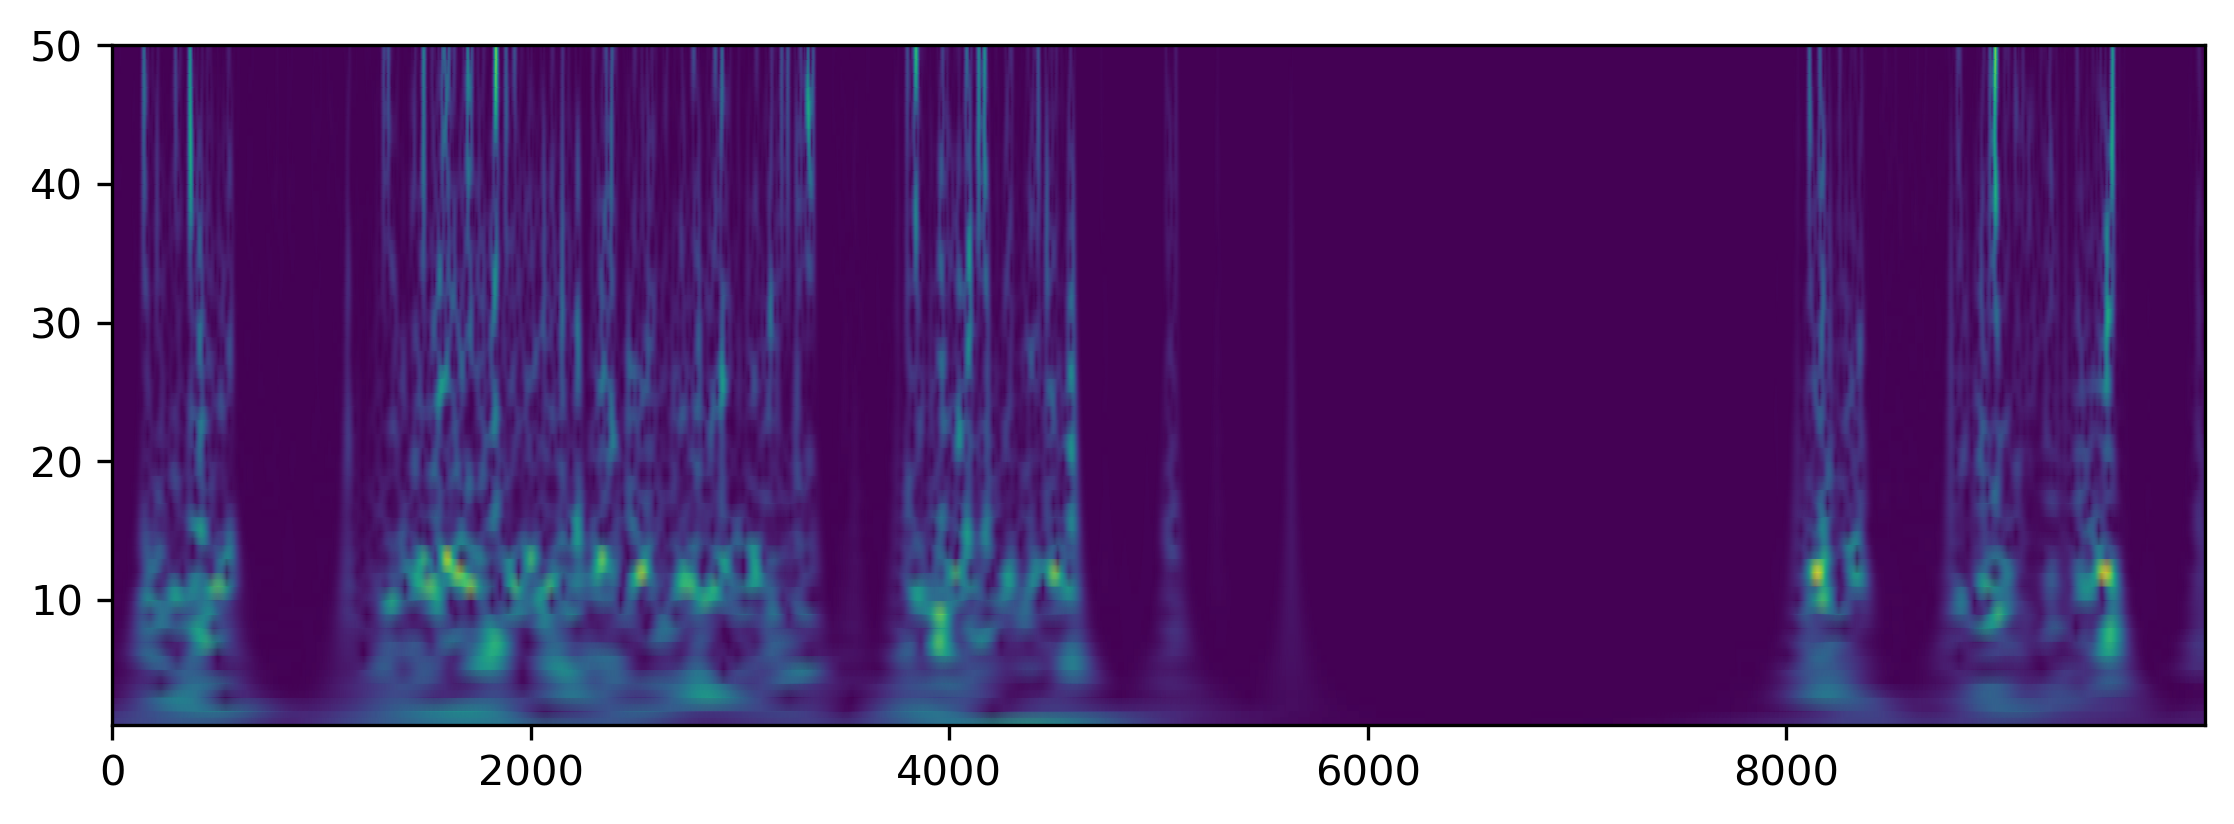

In [133]:
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (9, 3)
mpl.rcParams["figure.dpi"] = 300
fly_id = 3
expmt_name = "24h_bright"
node_name = "hindlegL"

vels = velocities_dict[expmt_name][:, node_names.index(node_name), fly_id][0:10000]
vels_len = vels.shape[0]

fs = 100
w = 25
freq = np.linspace(1, fs / 2, 50)
widths = w * fs / (2 * freq * np.pi)

cwtmatr = scipy.signal.cwt(vels, scipy.signal.morlet2, widths, w=w)
plt.pcolormesh(
    np.arange(vels_len), freq, np.abs(cwtmatr), cmap="viridis", shading="gouraud"
)
plt.show()
